importing Jupyter notebook from proj_env.ipynb
{'Serve Apple Salad to Person in Red': {('Go to Green Apple', 'Take Green Apple', 'Go to Red Apple', 'Take Red Apple', 'Go to Knife', 'Prepare Green Apple', 'Prepare Red Apple', 'Go to Mixing Bowl', 'Prepare Apple Salad', 'Place Apple Salad on Plate', 'Serve plate to Person in Red'), ('Go to Red Apple', 'Take Red Apple', 'Go to Green Apple', 'Take Green Apple', 'Go to Knife', 'Prepare Red Apple', 'Prepare Green Apple', 'Go to Mixing Bowl', 'Prepare Apple Salad', 'Place Apple Salad on Plate', 'Serve plate to Person in Red')}, 'Serve Cheese Platter to Person in White': {('Go to White Cheese', 'Take White Cheese', 'Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to Knife', 'Prepare White Cheese', 'Prepare Yellow Cheese', 'Go to Plate', 'Place White Cheese on Plate', 'Place Yellow Cheese on Plate', 'Serve plate to Person in White'), ('Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to White Cheese', 'Take White Cheese', 'Go to Knife', 'Prepare

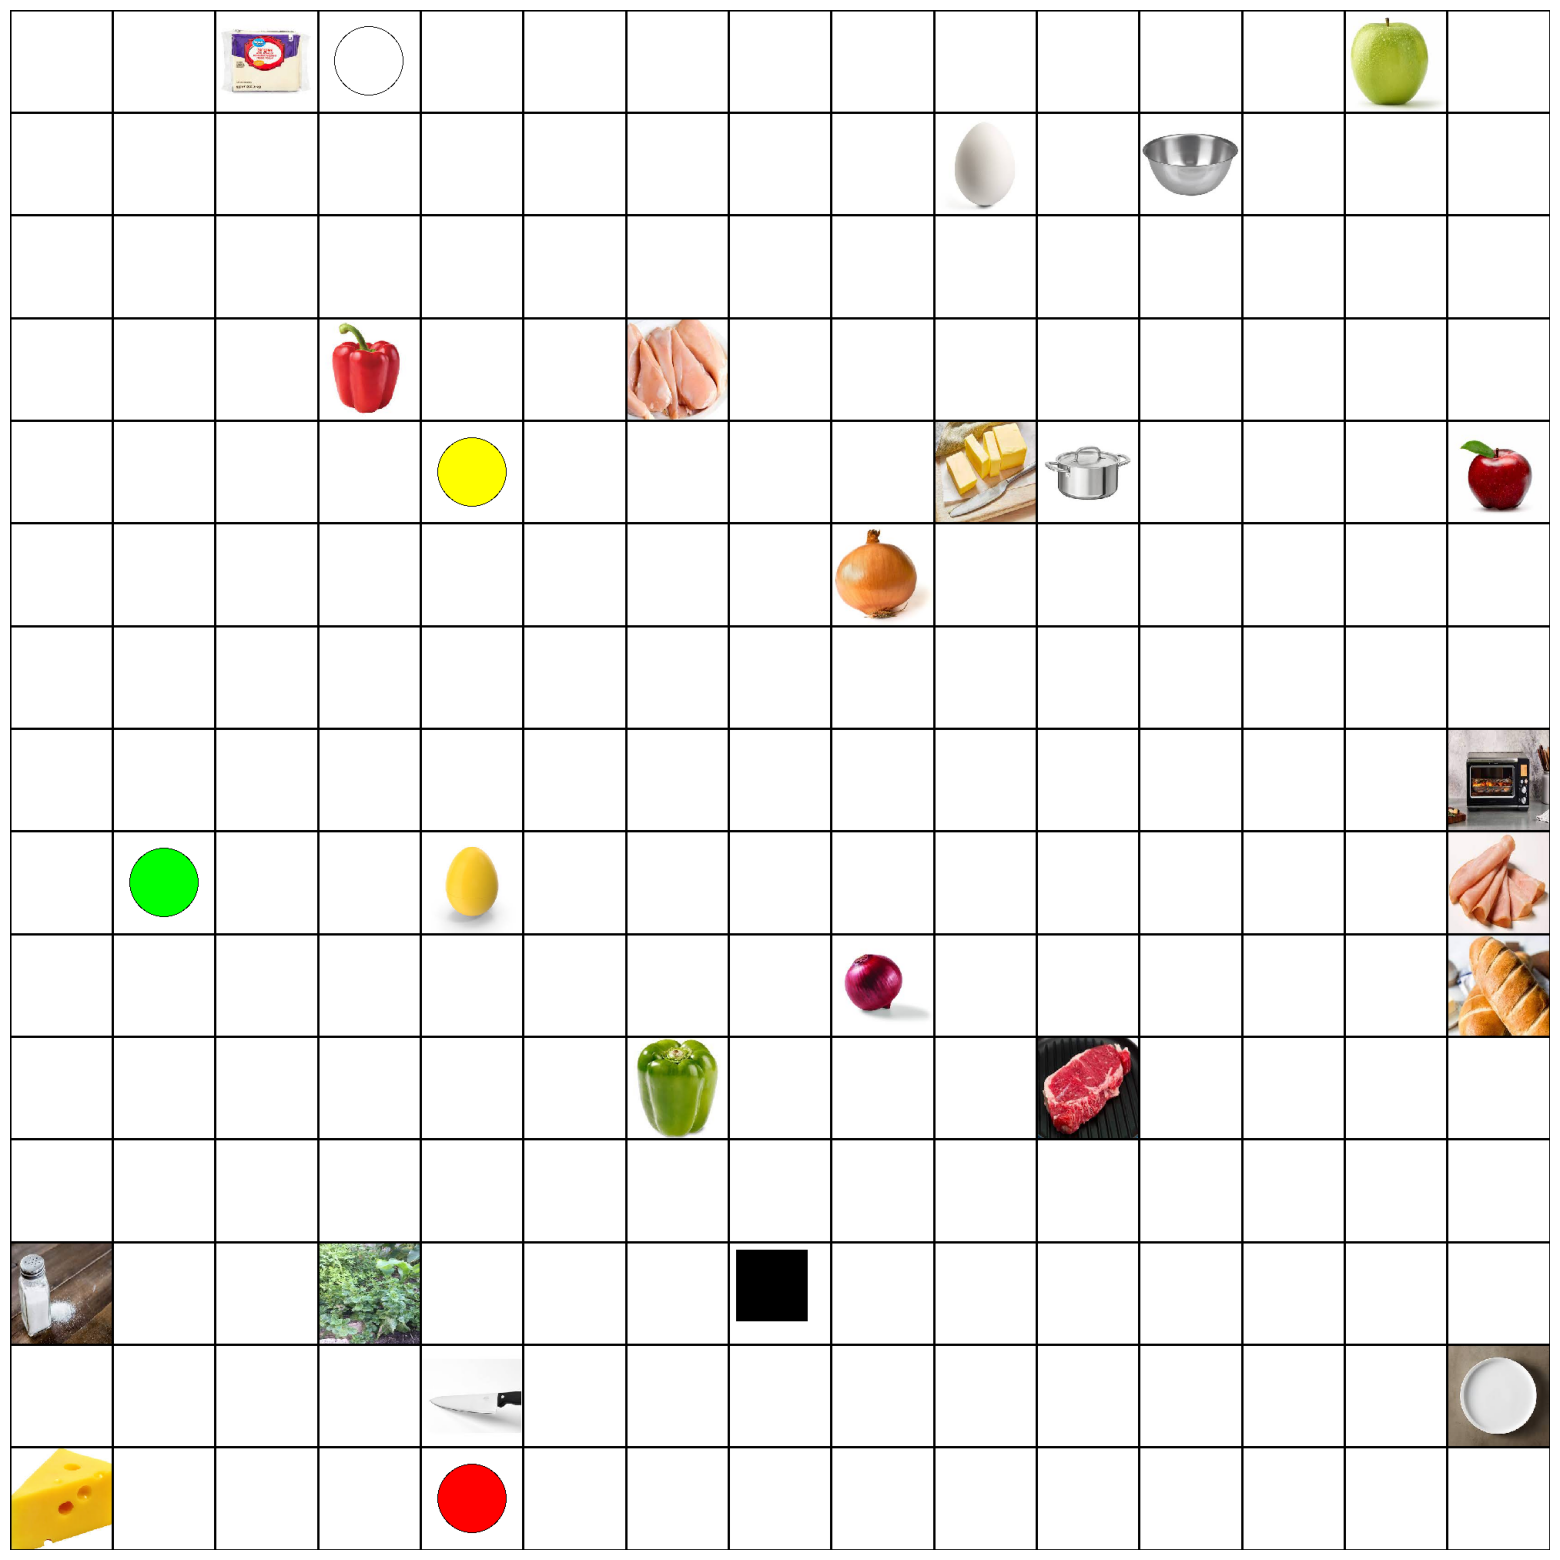

{'distance to Red Apple': 15.0, 'distance to Red Onions': 4.0, 'distance to Yellow Onions': 8.0, 'distance to Bread': 10.0, 'distance to Yellow Cheese': 9.0, 'distance to White Cheese': 17.0, 'distance to Red Bell Pepper': 13.0, 'distance to Green Bell Pepper': 3.0, 'distance to Green Apple': 18.0, 'distance to Yellow Egg': 7.0, 'distance to White Egg': 13.0, 'distance to Butter': 10.0, 'distance to Ham': 11.0, 'distance to Red Meat (Beef)': 5.0, 'distance to White Meat (Turkey)': 10.0, 'distance to Salt': 7.0, 'distance to Herbs': 4.0, 'distance to Pot': 11.0, 'distance to Oven': 12.0, 'distance to Knife': 4.0, 'distance to Mixing Bowl': 15.0, 'distance to Plate': 8.0, 'distance to Red Guest': 5.0, 'distance to White Guest': 16.0, 'distance to Green Guest': 10.0, 'distance to Yellow Guest': 11.0}
[]


In [1]:
import gym
import random
import import_ipynb
import proj_env
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import json
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import random


down = np.array([1,0])
up = np.array([-1,0])
right = np.array([0,1])
left = np.array([0,-1])

action_to_direction = {1: right,2: left,3: down,4: up}


food_list = ["RedApple", "RedOnions", "YellowOnions", "Bread", "YellowCheese", "WhiteCheese",
         "RedBellPepper", "GreenBellPepper", "GreenApple", "YellowEgg", "WhiteEgg", "Butter",
         "Ham", "RedMeat", "WhiteMeat", "Salt", "Herbs"]

tools_list =[ "Pot", "Oven", "Knife", "MixingBowl"]

guest_list = ["Red","White","Green","Yellow"]



In [2]:
def create_env(seed):
    random.seed(seed)

    the_n_env = proj_env.GridWorldEnv(render_mode='rgb_array')
    the_n_env.reset(seed = seed)
    return the_n_env

In [3]:
def show_env(env):
    image_array = env._render_frame()

    plt.figure(figsize=(20, 20))
    # Display the image array
    plt.imshow(image_array)
    plt.axis('off')  # Hide the axis
    plt.show()

2000


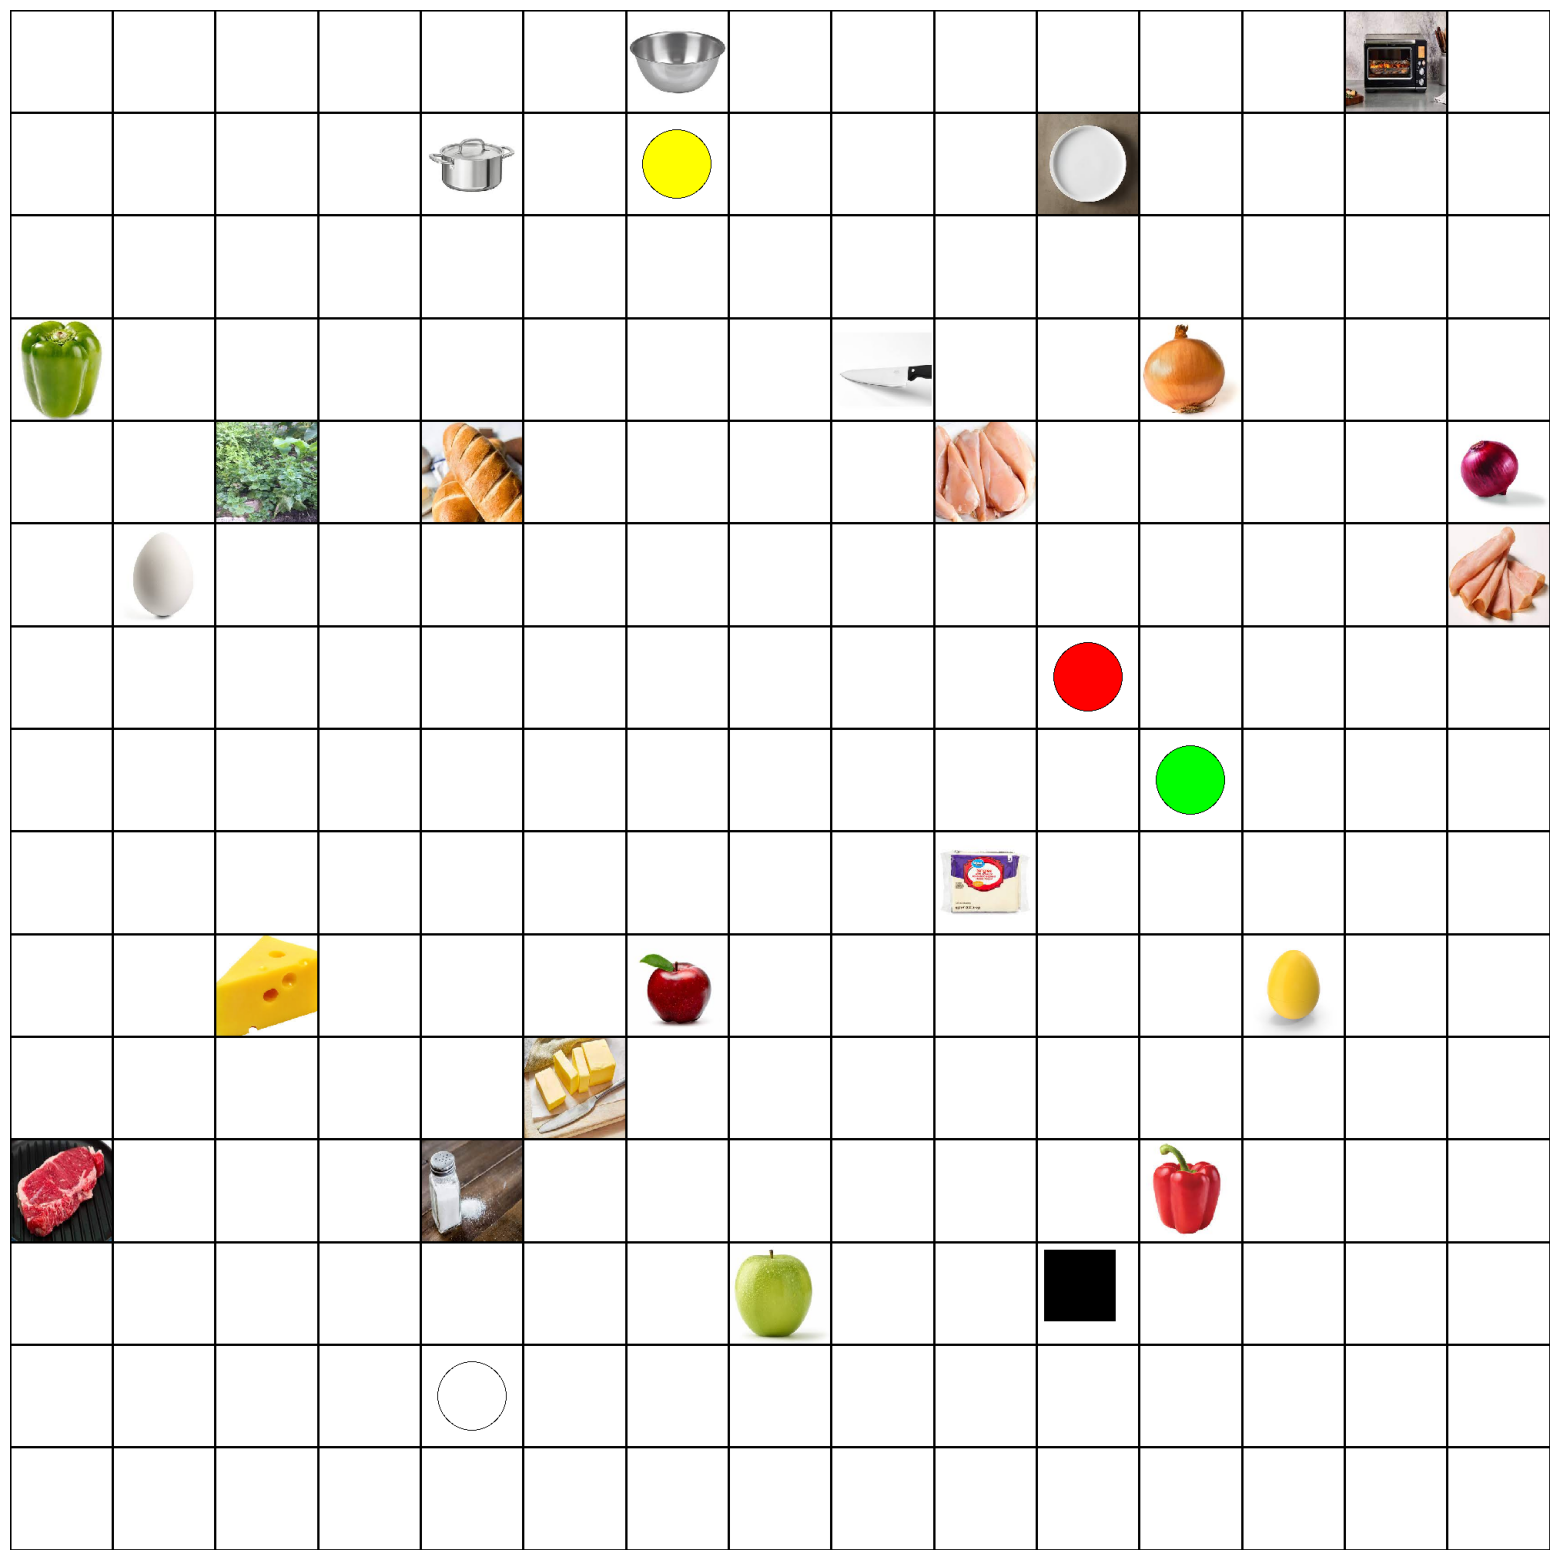

In [4]:

the_n_env = create_env(0)
show_env(the_n_env)
original_loc = the_n_env._Agent_location
plate_loc = the_n_env._Plate_location

size = the_n_env.size

In [5]:
def movingList(distance):
    
    x = distance[0]
    y = distance[1]
    lst = []
    a_lst = []
    if x < 0:
        for i in range(x,0):
            lst.append(1)
            a_lst.append("Right")
    elif x > 0:
        for i in range(x):
            lst.append(2)
            a_lst.append("Left")
    if y < 0:
        for i in range(y,0):
            lst.append(3)
            a_lst.append("Down")
    elif y > 0:
        for i in range(y):
            lst.append(4)
            a_lst.append("Up")

    return lst, a_lst

diff_loc = dict()
act_loc = dict()
for f in food_list:
    loc = getattr(the_n_env, "_"+f + "_location")
    distance = original_loc - loc
    x = distance[0]
    y = distance[1]
    lst,a_lst = movingList(distance)
    diff_loc[f] = lst
    act_loc[f] = a_lst

    distance_p = plate_loc - loc
    lst,a_lst = movingList(distance_p)
    o_lst , oa_lst = movingList(-distance_p)
    k = "Plate-"+f
    diff_loc[k] = lst
    act_loc[k] = a_lst

    k = f+"-Plate"
    diff_loc[k] = o_lst
    act_loc[k] = oa_lst

    for t in tools_list:
        t_loc = getattr(the_n_env, "_"+t + "_location")
        distance = original_loc - t_loc
        lst,a_lst = movingList(distance)
        diff_loc[t] = lst
        act_loc[t] = a_lst  
        
        distance = loc - t_loc
        lst,a_lst = movingList(distance)
        k = f+"-"+t
        diff_loc[k] = lst
        act_loc[k] = a_lst

        lst,a_lst = movingList(-distance)
        k = t+"-"+f
        diff_loc[k] = lst
        act_loc[k] = a_lst

        distance_p = t_loc - plate_loc
        lst,a_lst = movingList(distance_p)
        o_lst , oa_lst = movingList(-distance_p)
        k = t+"-Plate"
        diff_loc[k] = lst
        act_loc[k] = a_lst

        k = "Plate-"+t
        diff_loc[k] = o_lst
        act_loc[k] = oa_lst

        for g in guest_list:
            g_loc = getattr(the_n_env, "_"+g + "_location")
            distance = t_loc - g_loc
            lst,a_lst = movingList(distance)
            k = t+"-"+g
            diff_loc[k] = lst
            act_loc[k] = a_lst

            distance_p = plate_loc - g_loc
            lst,a_lst = movingList(distance_p)
            k = "Plate-"+g
            diff_loc[k] = lst
            act_loc[k] = a_lst

        for others_t in tools_list:
            if others_t!=t:
                other_loc = getattr(the_n_env, "_"+others_t + "_location")
                distance = t_loc - other_loc
                lst,a_lst = movingList(distance)
                k = t+"-"+others_t
                diff_loc[k] = lst
                act_loc[k] = a_lst

                lst,a_lst = movingList(-distance)
                k = others_t+"-"+t
                diff_loc[k] = lst
                act_loc[k] = a_lst
        
    for other in food_list:
        if other!=f:
            other_loc = getattr(the_n_env, "_"+other + "_location")
            distance = loc - other_loc
            lst,a_lst = movingList(distance)
            k = f+"-"+other
            diff_loc[k] = lst
            act_loc[k] = a_lst

            lst,a_lst = movingList(-distance)
            k = other+"-"+f
            diff_loc[k] = lst
            act_loc[k] = a_lst


diff_loc["Plate-Plate"] = []


In [6]:
def get_vocab(f_name):
    info = dict()
    with open(f_name,"r") as f:
        d = json.load(f)
        for i in d["dataset"]:
            e = i["key"]
            if e not in info.keys():
                v = i["value"]
                n_v = set()
                for value in v:
                    n_v.add(tuple(value))
                info[e] = n_v
            else:
                value = info[e]
                v = i["value"]
                n_v = set()
                for elements in v:
                    n_v.add(tuple(elements))
                n_v = value.union(n_v)
                info[e] = n_v

    return info

In [7]:
def commandAnalysis(step):
    command = step.split(" ")[0]
    t = step.split(" ")[-1]
    target = ""
    target += t[0].upper()
    target += t[1:].lower()
    if target == "Onion":
        target = step.split(" ")[-2]+"Onions"
    elif target == "Apple" or target == "Egg" or target == "Meat" or target == "Cheese":
        target = step.split(" ")[-2]+target
    elif target == "Pepper":
        target = step.split(" ")[-3]+"Bell"+target
    elif target == "Bowl":
        target = "Mixing"+target
    elif target == "(turkey)":
        target = "WhiteMeat"
    elif target == "(beef)":
        target = "RedMeat"
    else:
        target = target
    
    return command, target

def get_action(info,diff_loc):
    optimal_action = dict()
    for key in info.keys():
        value = info[key]
        big_v = []
        for v in value:
            small_v = []
            last_pos = original_loc
            last_reach = None
            for step in v:
                command, target = commandAnalysis(step)
                if command == "Go":
                    if last_reach == None:
                        small_v += diff_loc[target]
                        last_reach = target
                    else:
                        small_v += diff_loc[last_reach+"-"+target]
                        last_reach = target
                elif command == "Take":
                    small_v.append(5)
                
                elif command == "Prepare":
                    small_v.append(6)

                elif command == "Place":
                    k = last_reach+"-"+"Plate"
                    small_v += diff_loc[k]
                    small_v.append(6)
                    last_reach = "Plate"

                elif command == "Serve":
                    k = last_reach+"-"+target
                    small_v += diff_loc[k]
                    small_v.append(7)
                    last_reach = None
            big_v.append(small_v)
        optimal_action[key] = big_v
    return optimal_action




In [8]:
def make_words_tokenize(optimal_action):
    tokenized = [word_tokenize(text) for text in optimal_action.keys()]

    all_tokens = [token for text in tokenized  for token in text]
    vocab = Counter(all_tokens)

    word_to_index = {word: i + 1 for i, (word, _) in enumerate(vocab.items())}
    print(word_to_index)

    tokenized_texts_indices = [[word_to_index[token] for token in text] for text in tokenized]

    # Define a maximum sequence length
    max_length = max(len(text) for text in tokenized_texts_indices)

    # Pad sequences with zeros
    padded_sequences = [text + [0] * (max_length - len(text)) for text in tokenized_texts_indices]

    return padded_sequences, word_to_index, max_length

def make_action_tensor(optimal_action, word_to_index, max_length):
    opt_short_action = []
    for k in optimal_action.keys():
        v = optimal_action[k]

        if len(v) > 1:
            first = len(v[0])
            second = len(v[1])
            if first < second:
                opt_short_action.append(v[0])
            else:
                opt_short_action.append(v[1])
        else:
            opt_short_action.append(v[0])

    print(opt_short_action)


    max_l =  max(len(act) for act in opt_short_action)


    padded_act = [act + [0] * (max_l - len(act)) for act in opt_short_action]
    return padded_act

def get_test_tokeinize(test_action, my_dictionary):
    
    b_lst = []
    for text in test_action.keys():
        tokenized = word_tokenize(text.lower())
        lst = []
        for w in tokenized:
            if w in my_dictionary.keys():
                lst.append(my_dictionary[w])
            else:
                lst.append(my_dictionary["<unk>"])
        if len(lst)<20:
            lst += [0]*(20-len(lst))

        b_lst.append(lst)
    return b_lst

In [9]:
# obs_lst = []
# for f in food_list:
#     obs_lst.append(getattr(the_n_env, "_"+f + "_location"))
# for t in tools_list:
#     obs_lst.append(getattr(the_n_env, "_"+t + "_location"))
# for g in guest_list:
#     obs_lst.append(getattr(the_n_env, "_"+g + "_location"))
# obs_lst.append(the_n_env._Agent_location)
# obs_lst.append(the_n_env._Plate_location)
# obs_lst = torch.tensor(np.array(obs_lst)).float()

# obs_mean = torch.mean(obs_lst, dim=0)  # Mean (2 values)
# obs_std = torch.std(obs_lst, dim=0)  # Standard deviation (2 values)
# obs_summary = torch.cat((obs_mean, obs_std))  # Summary vector (4 values)
# print(obs_summary.shape)
# print(obs_summary)

In [20]:
class TextEncode(nn.Module):
    def __init__(self, bert):
        super(TextEncode, self).__init__()
        self.bert = bert

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output
    

class ObsEncode(nn.Module):
    def __init__(self, obs_dim, hidden_dim):
        super(ObsEncode, self).__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        

    def forward(self, obs):
        return self.fc1(obs)
    
class CombinedModel(nn.Module):
    def __init__(self, obs_encoder, text_encoder, action_decoder, seq_len):
        super(CombinedModel, self).__init__()
        self.obs_encoder = obs_encoder
        self.text_encoder = text_encoder
        self.action_decoder = action_decoder
        self.seq_len = seq_len

    def forward(self, obs, input_ids, attention_mask):
        encoded_text = self.text_encoder(input_ids, attention_mask)
        obs_encode = self.obs_encoder(obs)
        obs_data_flattened = obs_encode.view(-1, obs_encode.shape[0]*obs_encode.shape[1])
        obs_data_repeated = obs_data_flattened.repeat(encoded_text.shape[0], 1)

        combined_data = torch.cat((obs_data_repeated, encoded_text), dim=1)


        #print(combined_data.shape)
        result = self.action_decoder(combined_data)
        #print("get result")
        return result

class ActionDecode(nn.Module):
    def __init__(self, input_size, hidden_size, num_actions, num_layers, seq_len):
        super(ActionDecode, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_actions)
        self.seq_len = seq_len


    def forward(self, combined):
        #print("Step 1 on decoder")
        x = combined.unsqueeze(1).repeat(1, self.seq_len, 1)
        lstm_out, _ = self.lstm(x)
        #print("Step 2 on decoder")
        out = self.fc(lstm_out)
        out = out.contiguous().view(-1, out.shape[-1])
        #print("Step 3 on decoder")
        return out



In [21]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, texts, actions):
        self.texts = texts # Convert to tensor if not already
        self.actions = torch.tensor(actions)




    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        action = self.actions[idx]
        return text, action

In [28]:
from transformers import BertModel, BertTokenizer

def text_encoder(optimal_action):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    texts = list(optimal_action.keys())
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    
    with torch.no_grad():
        model_output = bert_model(**encoded_inputs)
        return model_output.last_hidden_state

def training(batch_size,lr,epoch,obs_info,diff_loc):
    info = get_vocab("699_recipe_data.json")
    optimal_action = get_action(info,diff_loc)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    padded_act = make_action_tensor(optimal_action, "", 0)

    dataset = CustomDataset(list(optimal_action.keys()), padded_act)
    
    train_loader = DataLoader(dataset, batch_size)

    criterion = nn.CrossEntropyLoss()

    bert_model = BertModel.from_pretrained('bert-base-uncased')
    text_encoder = TextEncode(bert_model)

    obs_encoder = ObsEncode(obs_info.shape[1], 32)

    action_decoder = ActionDecode(768+obs_info.shape[0]*obs_info.shape[1], 122, 8, 2, len(padded_act[-1]))

    combined_model = CombinedModel(obs_encoder, text_encoder, action_decoder, 200)
    
    optimizer = torch.optim.Adam(combined_model.parameters(), lr)

    loss = nn.HuberLoss()

    pbar = tqdm(range(epoch), desc="Training", unit="epoch")
    for epoch in pbar:
        for text, target in train_loader:
            torch.set_grad_enabled(True)
            optimizer.zero_grad()

            encoded_inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
            input_ids = encoded_inputs['input_ids']
            attention_mask = encoded_inputs['attention_mask']
            
            
            r = combined_model(torch.tensor(obs_info), input_ids, attention_mask)
            
            target = target.view(-1)
            loss = criterion(r, target.long())
            loss.backward()
            optimizer.step()
        pbar.set_postfix(Loss=loss,The_epoch=epoch+1)
    return combined_model

    

        
    
    
    

In [29]:
obs_lst = []
for f in food_list:
    obs_lst.append(getattr(the_n_env, "_"+f + "_location"))
for t in tools_list:
    obs_lst.append(getattr(the_n_env, "_"+t + "_location"))
for g in guest_list:
    obs_lst.append(getattr(the_n_env, "_"+g + "_location"))
obs_lst.append(the_n_env._Agent_location)
obs_lst.append(the_n_env._Plate_location)
obs_lst = torch.tensor(np.array(obs_lst)).float()
print(obs_lst.shape)
training(3,0.001,100,obs_lst,diff_loc)

torch.Size([27, 2])
[[2, 2, 2, 5, 2, 4, 4, 4, 5, 1, 1, 4, 4, 4, 4, 4, 4, 6, 2, 2, 4, 4, 4, 6, 1, 1, 1, 1, 3, 6, 3, 3, 3, 3, 3, 7], [2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 5, 1, 1, 1, 1, 1, 1, 1, 4, 5, 2, 4, 4, 4, 4, 4, 6, 1, 1, 4, 4, 6, 6, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7], [2, 4, 4, 4, 4, 5, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 5, 1, 1, 1, 1, 1, 1, 4, 6, 2, 2, 4, 4, 4, 6, 1, 1, 1, 1, 3, 6, 1, 3, 3, 3, 3, 3, 3, 7], [1, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 6, 2, 2, 4, 4, 4, 6, 1, 1, 1, 1, 3, 6, 2, 2, 2, 2, 7], [2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 5, 1, 1, 1, 3, 5, 2, 4, 4, 4, 4, 4, 4, 5, 1, 1, 1, 1, 4, 6, 2, 2, 4, 4, 4, 6, 1, 1, 1, 1, 1, 1, 1, 6, 2, 2, 2, 3, 6, 3, 3, 3, 3, 3, 7], [2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 2, 2, 2, 2, 2, 2, 4, 6, 2, 2, 4, 4, 4, 6, 1, 1, 1, 1, 3, 6, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7], [2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 5, 1, 1, 1, 1, 

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/ff/l05d4kh92k1cplt20pm7pbb40000gn/T/ipykernel_34568/814671118.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = combined_model(torch.tensor(obs_info), input_ids, attention_mask)
Training:   2%|▏         | 2/100 [00:10<08:41,  5.32s/epoch, Loss=tensor(nan, grad_fn=<NllLossBackward0>), The_epoch=2]

: 